<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/dqn_pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import random
import numpy as np

import gym

import matplotlib.pyplot as plt
%matplotlib inline

## Load GYM environment

In [2]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States shape: {}'.format(STATE_SHAPE))

Actions: 6
States shape: (210, 160, 3)


In [3]:
env.__dict__

{'_elapsed_steps': 0,
 '_episode_started_at': None,
 '_max_episode_seconds': None,
 '_max_episode_steps': 10000,
 'action_space': Discrete(6),
 'env': <gym.envs.atari.atari_env.AtariEnv at 0x7fa3ab4aa198>,
 'metadata': {'render.modes': ['human', 'rgb_array']},
 'observation_space': Box(210, 160, 3),
 'reward_range': (-inf, inf)}

In [4]:
env.observation_space.shape[0]

210

## Example of a state

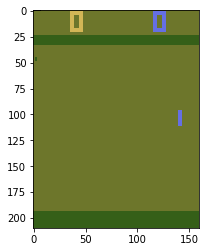

In [5]:
s = env.reset()
_=plt.imshow(s)

## DQN

In [0]:
# Train a DQN model here

In [7]:
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Dense, Flatten
from keras.models import Model, load_model, Sequential

# def loss(q1, q2):
#     return tf.reduce_sum(tf.square(q1 - q2))

def make_model():
    model = Sequential()
    inputs = Input((210, 160, 3))
    c1 = Conv2D(128, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(128, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    f1 = Flatten()(p1)
    out = Dense(2, activation='sigmoid')(f1)
    model = Model(inputs=inputs, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [0]:
from collections import deque
import random
import tensorflow as tf
import keras.backend as K

DISCOUNT = .9
MEMORY_LIMIT = 5000
memory = deque([], maxlen=MEMORY_LIMIT)

def reset_memory():
    memory = deque([], maxlen=MEMORY_LIMIT)

UP_ACTION = 2
DOWN_ACTION = 3
ACTIONS = [UP_ACTION, DOWN_ACTION]
ACT_DICT = {
    '2': 0,
    '3': 1
}
EXPLORE_COEF = .5

In [0]:
def choose_action(model, state):
    if np.random.rand() <= EXPLORE_COEF:
        return ACTIONS[np.random.randint(0, len(ACTIONS))]
    q = model.predict(state.reshape(1, state.shape[0], state.shape[1], state.shape[2]))
    print(q)
    return ACTIONS[np.argmax(q[0])]

def prep_batch(model, batch_size):
    if batch_size > MEMORY_LIMIT:
        Warning('batch size should not be larger than max memory size. Setting batch size to memory size')
        batch_size = MEMORY_LIMIT

    batch_size = min(batch_size, len(memory))

    inputs = []
    targets = []
    batch = random.sample(list(memory), batch_size)
    random.shuffle(batch)
    for state, action, next_state, reward in batch:
        state = state.reshape(1, state.shape[0], state.shape[1], state.shape[2])
        next_state = next_state.reshape(1, next_state.shape[0], next_state.shape[1], next_state.shape[2])
        inputs.append(state)
        target = model.predict(state)[0]

        if reward:
            target[ACT_DICT[str(action)]] = reward
        else:
            # reward + gamma * max_a' Q(s', a') bellman equation
            model_sa = np.max(model.predict(next_state)[0])
            target[ACT_DICT[str(action)]] = reward + DISCOUNT * model_sa
        targets.append(target)
    
    return np.vstack(inputs), np.vstack(targets)

def replay(model, batch_size):
    inputs, targets = prep_batch(model, batch_size)
    print(targets)
    loss = model.train_on_batch(inputs, targets)
    return loss

def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Virtual display and video recording for Colab

In [10]:
RECORD_VIDEO = True

if RECORD_VIDEO:
  
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [14]:
len(memory)

13

In [15]:
replay(model, BATCH_SIZE)[0]

13 13
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


0.0

In [13]:
import sys

EPOCHS = 6500
BATCH_SIZE = 32

if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env


# keep track of past record_len results
record_len = 100
record = deque([], record_len)

reset_tf_session()
model = make_model()
print(model.summary())
reset_memory()

for i in range(EPOCHS):
    state = env_sim.reset()
    reward = 0
    loss = 0

    env_sim.render()

    # q = model.predict(state.reshape(1, state.shape[0], state.shape[1], state.shape[2]))
    # print(state.reshape(1, state.shape[0], state.shape[1], state.shape[2]).shape)
    # print()
    # # print(len(q[0]), len(q[0][0]), len(q[0][0][0]))
    # break

    done = False
    while done == False:
        
        action = choose_action(model, state)
        prev_state = state
        state, reward, done, _ = env_sim.step(action)
        
        memory.append((prev_state, action, state, reward))
        loss += replay(model, BATCH_SIZE)[0]

        print(reward, action)

    break

    if i % 100 == 0:
        sys.stdout.flush()
        sys.stdout.write('epoch: {:04d}/{} | loss: {:.3f} | win rate: {:.3f}\r'.format(i+1, EPOCHS, loss, sum(record)/len(record) if record else 0)) 
    record.append(reward if reward == 1 else 0)









Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 160, 128)     3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 160, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 105, 80, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1075200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2150402   
Total params: 2,301,570
Trainable params: 2,301,570
Non-trainable params: 0
__________________________________________

KeyboardInterrupt: ignored

## Run simulation

In [0]:
if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env

state = env_sim.reset()
totalReward = 0

UP_ACTION = 2
DOWN_ACTION = 3

for _ in range(1000):
    env_sim.render()
    
    q = model.predict(state)
    state, reward, done, _ = env_sim.step(np.argmax(q[0]))
    totalReward += reward
    if done:        
        break
    
    if not RECORD_VIDEO:
        time.sleep(1./30)
        
env_sim.close()

print('Total reward = {}'.format(totalReward))

## Show the video

In [0]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
show_video()